# Project 1 – Taylor Series and Floating Point Error
## MATH 3316 High Performance Scientific Computing, Fall 2016

Author: Paul Herz

The designated programming language for this project was C++, built in Xcode and compiled with Clang (Apple LLVM 8.0.0) using the C++14 dialect.

### Structure of this Project

This project's file structure follows the GNU-style C++ project standard.

In [16]:
%ls ..

HPSCProject1.xcodeproj/ data/                   reports/
Makefile                lib/                    src/
bin/                    notebooks/


Excluding the `.xcodeproj` file, which was used for integration with the Xcode IDE, debugging, and profiling purposes, each item in the project directory serves the following purpose:

- `Makefile`: GNU Make project build automation definitions
- `bin/`: compiled binaries. Make will put binaries here by default.
- `data/`: where calculated data is stored after program execution. Files are `.txt` files containing real numbers, space delimited to denote row items, and newline delimited to denote new rows.
- `lib/`: reused libraries that are not part of this project specifically. Contains my rewrite of the Matrix library ([phrz/matrix](https://github.com/phrz/matrix)).
- `notebooks/`: Python 3 Jupyter notebooks, notably the one used to generate this report.
- `reports/`: PDFs generated from the Jupyter notebooks via `nbconvert` and `pdflatex`.
- `src/`: contains the main mathematical routines described in this report, which are used to generate the raw data in `data/`.

### Using this Project

#### Prerequisites
- A Unix or Unix-like OS (e.g. macOS or Linux)
- A compiler with support for C++14 (LLVM or GNU toolchain)
- Python ≥3.5
- The latest Jupyter distribution
- LaTeX with `pdflatex`
- GNU Make ≥3.81

#### Building this project
This project provides several GNU Make targets, with a handful of them being especially useful.

`make all` (default) - will compile binaries, execute them to generate data files, execute Jupyter notebooks under fresh kernels with just-generated data files, and convert them to PDFs in `/reports`.

`make all_bin` - will compile binaries for part A and B of this project.

`make all_data` - will compile binaries and execute them to generate data files.

`make clean` - will delete all compiled binaries, generated data, executed notebook copies (but not the original notebooks), and **report PDFs**.

Below, find attached the full Makefile:

In [17]:
%cat ../Makefile

#
#  Makefile
#  HPSCProject1
#
#  Created by Paul Herz on 9/3/16.
#  Copyright © 2016 Paul Herz. All rights reserved.
#

TARGETA = HPSCProject1_a
TARGETB = HPSCProject1_b

CXX = g++
CFLAGS = -std=c++14

SRC = src/
LIB = lib/
BIN = bin/
ROOT = $(shell pwd)/
DATA = data/
NB = notebooks/
RP = reports/

AFILES = proj1_a.cpp
BFILES = proj1_b.cpp
LIBFILES = Matrix.cpp Vector.cpp

NOTEBOOK_A = $(NB)proj1_a.ipynb
NOTEBOOK_B = $(NB)proj1_b.ipynb

REPORT_A = $(RP)proj1_a.pdf
REPORT_B = $(RP)proj1_b.pdf



################################
# All target                   #
################################

all: all_bin all_data all_reports



################################
# Application binaries         #
################################

all_bin: $(TARGETA) $(TARGETB)

$(TARGETA):
	$(CXX) $(CFLAGS) -o $(BIN)$(TARGETA) -I $(LIB) $(addprefix $(LIB), $(LIBFILES)) $(addprefix $(SRC), $(AFILES))

$(TARGETB):
	$(CXX) $(CFLAGS) -o $(BIN)$(TARGETB) -I $(LIB) $(addprefix $(LIB), $(LIBFILES)) $(addprefix

## Part A – Approximation of a Function by Taylor Polynomials

Part A of this project concerned itself with programmatically constructing and then evaluating Taylor polynomials of varying length for a given function, $f(x) = e^x$.

### Goals

Specifically, I was to generate a Taylor polynomial $p_n(x)$ to approximate $f(x)$, where $n$ was the polynomial's degree. I had to generate three distinct Taylor polynomials $p_n(x)$ for $n=\{4,8,12\}$. I was then supposed to evaluate all three Taylor polynomials, as well as the true function $f(x)$, over the range $[-1.0, 1.0]$ for the variable $x$. Lastly, with these datapoints for four functions over the given range, I had to calculate the absolute error of each Taylor polynomial in approximating the true function $f(x)$ over the given range for $x$.

### Math Background

#### Taylor series

The Taylor series for $f(x)=e^x$ is defined as follows:

$$
e^x = \sum_{n=0}^{\infty} \frac{x^n}{n!}
$$

which expands to:

$$
e^x = 1 + x + \frac{x^2}{2!} + \frac{x^3}{3!} + \cdots
$$

In this program's calculations, I approximate this full Taylor series, and thus approximate $f(x)$, by using *Taylor polynomials*, effectively truncated Taylor series. Unlike Taylor series, which are infinite, Taylor polynomials can be calculated in finite time. What's more, as the data will demonstrate, these approximations, depending on parameters like polynomial degree, can create acceptably accurate numerical results for our purposes.

#### Absolute error

Absolute error is defined for any true value $x$ and any approximation of that true value (approximate value) $\hat{x}$ as the absolute value of the difference between the two:

$$
\epsilon = |x - \hat{x}|
$$

In this project, I will calculate the absolute error of an approximate *function* $\hat{f}(x)$ in approximating a *true function* $f(x)$. Thus the absolute error is not a value, but itself a function in terms of $x$:

$$
\epsilon(x) = |f(x) - \hat{f}(x)|
$$

### Implementation Requirements

#### The Nested Multiplication Function

First, as an exercise in both learning and performative efficiency, I was to implemented a generic form of Horner's method for polynomial evaluation. The function `nest`, located in `nest.cpp` and sampled below, evaluated a polynomial of the form $p = a_0 +a_1 x+a_2 x^2+\ldots+a_n x^n$. Coefficients $\{a_0,\ldots,a_n\}$ are passed to the function as a row matrix `a` of size $n+1$. The second parameter is a real number `x`, the present value of the variable $x$ for this iteration of evaluation.

#### Calculation Routine

Specific requirements were provided in how to approach the end goals outlined above. The row vector `z` was to be a linearly-spaced collection of values in the range $[-1.0,1.0]$, with an incremental step of $+0.01$. This row vector would be iterated upon in order to provide incremental values of $x$ in evaluating $f(x)$ and the Taylor polynomials $p_{4}(x), p_{8}(x), p_{12}(x)$. These functions' results for $x_i \in z$ would be stored in `f`, `p4`, `p8`, and `p12` respectively. The absolute errors over $z$ of $p_n(x)$ in approximating $f(x)$ would be stored in `err4`, `err8`, and `err12` respectively.

### Implementation

#### The Nested Multiplication Function

The `nest` function, implementing Horner's method, actually evaluates the polynomial from the inside (deepest level) out as $p=a_0+x(a_1+x(\ldots a_{n_1}+x(a_n)\ldots))$, significantly reducing the number of calculations required to evaluate any $n$-length polynomial and eliminating the need to accumulate $x^i$ for each polynomial term in a separate variable.

As an added optimization, `nest` employs the C++ Standard Library's fused multiply-add method ([std::fma](http://en.cppreference.com/w/cpp/numeric/math/fma)), which on compatible processors maps to a single [CPU operation](https://en.wikipedia.org/wiki/Multiply–accumulate_operation). This reduces the computer arithmetic operations required in Horner's method ($2n$) to an impressive $n$ operations for an $n^{th}$-degree polynomial on most modern CPUs.


In [18]:
%cat ../src/nest.cpp

//
//  nest.cpp
//  HPSCProject1
//
//  Created by Paul Herz on 8/31/16.
//  Copyright © 2016 Paul Herz. All rights reserved.
//

#include <iostream>

#include "Matrix.h"
#include "Vector.h"

#ifndef nest_cpp
#define nest_cpp

using namespace PH;

double nest(Matrix& a, double x) {
	// evaluate the following with nested multiplication:
	//
	// p = a_0 + a_1 x + a_2 x^2 + ... + a_{n-1} x^{n-1} + a_n x^n.
	//
	// the [n+1] coefficients a[0]...a[n] are in Vector a.
	// nest(a,x) should return p.
	
	// nested form: p = a_0 + x( a_1 + x( ... a_n-1 + x(a_n) ... ) )
	
	// begin total as = a_n
	double n = a.size() - 1;
	double total = a(n);
	
	// this weird looking for loop
	// avoids size_t to zero comparison warnings,
	// and just allows the Index to wrap around where
	// it's greater than n.
	
	for(Index i = n - 1; i < n; --i) {
		// fma(x,y,z) = x * y + z
		// total * x + a_i
		total = std::fma(total, x, a(i));
	}
	
	return total;
}

#endif


#### Calculation Routine

The implementation of the overall calculation routines was very simple, with the main loop creating the $x$-axis as a linear span in `z`. Following that is the generation of the coefficients for the $12^{th}$-degree Taylor polynomials, followed by truncating them for the $8^{th}$-degree and $4^{th}$-degree coefficient arrays.

To this end, and for the sake of organized code, I created the convenience function `eulerExponentialTaylorCoefficients`, which creates an $n$-length row matrix of coefficients for the $n^{th}$-degree Taylor polynomial for $f(x)$. This function merely iteratively calculates $1/i!$ for all $i$ in $[0,n]$, and stores them in a row matrix. Following this, I used the `nest` method on each coefficient set iterating over `z`. Following that, absolute error of the polynomials in approximating $f(x)$ is calculated quickly with elementwise subtraction operations on the error matrices, and mapping the absolute value function over all elements of the matrix.

Finally, all relevant data structures are serialized to file for display in this report.

In [19]:
%cat ../src/proj1_a.cpp

//
//  proj1_a.cpp
//  HPSCProject1
//
//  Created by Paul Herz on 8/31/16.
//  Copyright © 2016 Paul Herz. All rights reserved.
//

#include <iostream>

#include "Matrix.h"
#include "Vector.h"
#include "nest.cpp"

using namespace PH;

// generate n coefficients
// for Taylor polynomial for e^x.
// 1/0!, 1/1!, 1/2!, etc. as a row matrix.
Matrix eulerExponentialTaylorCoefficients(Index n) {
	Matrix coefficients = Matrix(1, n);
	
	// factorial accumulator, starts as 1!
	int fact = 1;
	
	// for the number of coefficients required,
	// calculate 1/i! and set it in the row matrix.
	for(Index i = 0; i < n; ++i) {
		if(i != 0) {
			fact *= i;
		}
		coefficients(i) = 1.0 / fact;
	}
	
	return coefficients;
}


int main(int argc, const char * argv[]) {
	
	// use linSpace and nest to compute the following:
	
	// create the row vector
	// z = −1, −0.99, ... , 0.99, 1.0
	auto z = Matrix::linSpace(-1, 1, 1, 201);
	
	// Compute the vector p4 as the value of the
	// Taylor polynomial p4(x) for all poi

### Analysis

What follows is graphs of the data generated by the above program. I used Matplotlib to generate these graphs. First I configured the appearance of my graphs, and loaded the serialized data into Numpy.

In [20]:
%pylab inline
pylab.rcParams['figure.figsize'] = (10, 6)
matplotlib.rcParams.update({'font.size': 16})
matplotlib.rcParams.update({'axes.labelsize': 20})
matplotlib.rcParams.update({'xtick.labelsize': 12})
matplotlib.rcParams.update({'ytick.labelsize': 12})
matplotlib.rcParams.update({
        'font.family': 'Helvetica, Arial, sans-serif'
})

%config InlineBackend.figure_format = 'retina'

Populating the interactive namespace from numpy and matplotlib


In [21]:
names = ['z', 'p4', 'p8', 'p12', 
         'f', 'err4', 'err8', 'err12']
v = {}
for name in names:
    v[name] = loadtxt('../data/a/' + name + '.txt')

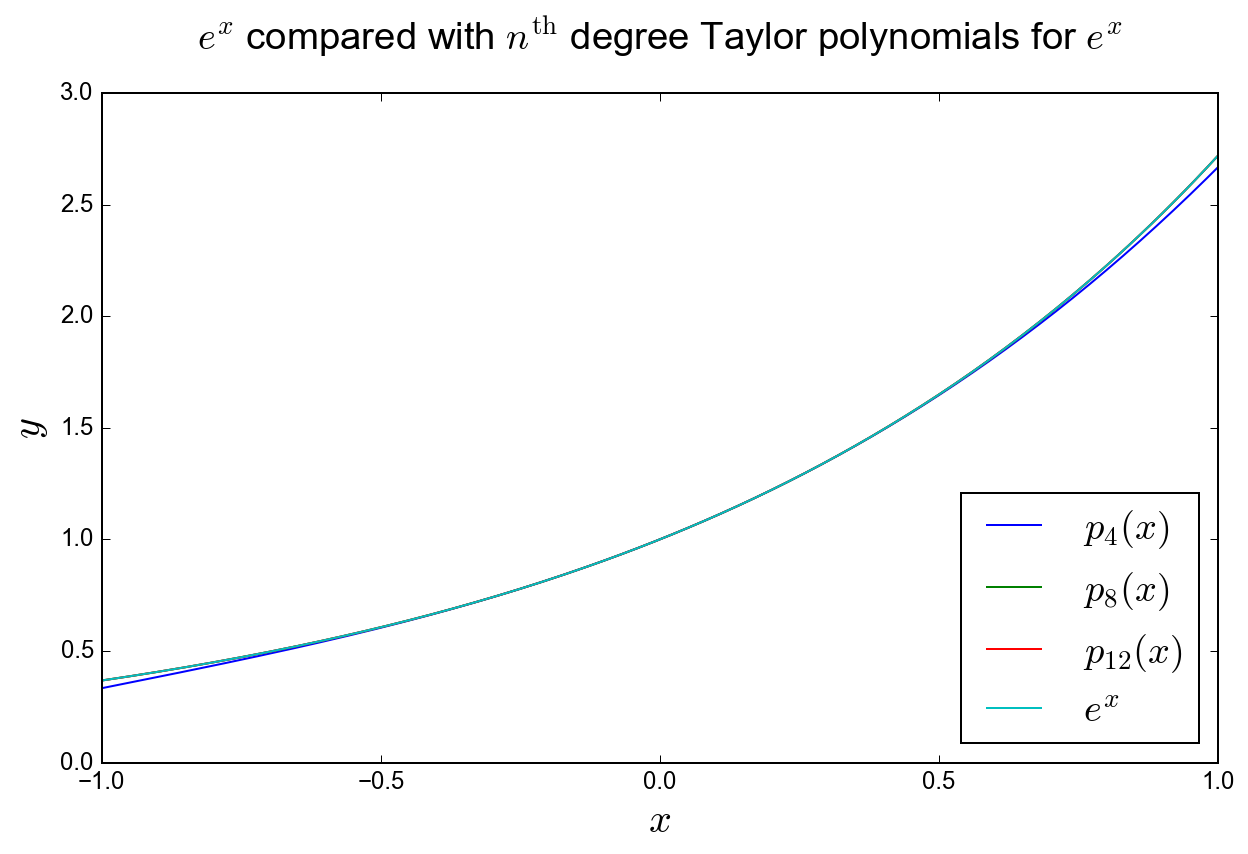

In [22]:
# Plot ex, p4(x), p8(x) and p12(x) 
# in the same figure window with different colors. 
# Add a legend, axis labels and title to the plot.

pylab.plot(v['z'], v['p4'], 
           v['z'], v['p8'], 
           v['z'], v['p12'],
           v['z'], v['f'])

pylab.legend(('$p_{4}(x)$',
              '$p_{8}(x)$',
              '$p_{12}(x)$',
              '$e^x$'), loc=4)

pylab.xlabel('$x$')
pylab.ylabel('$y$')
pylab.title('$e^x$ compared with $n^{\mathrm{th}}$ '
            'degree Taylor polynomials for $e^x$', y=1.05)

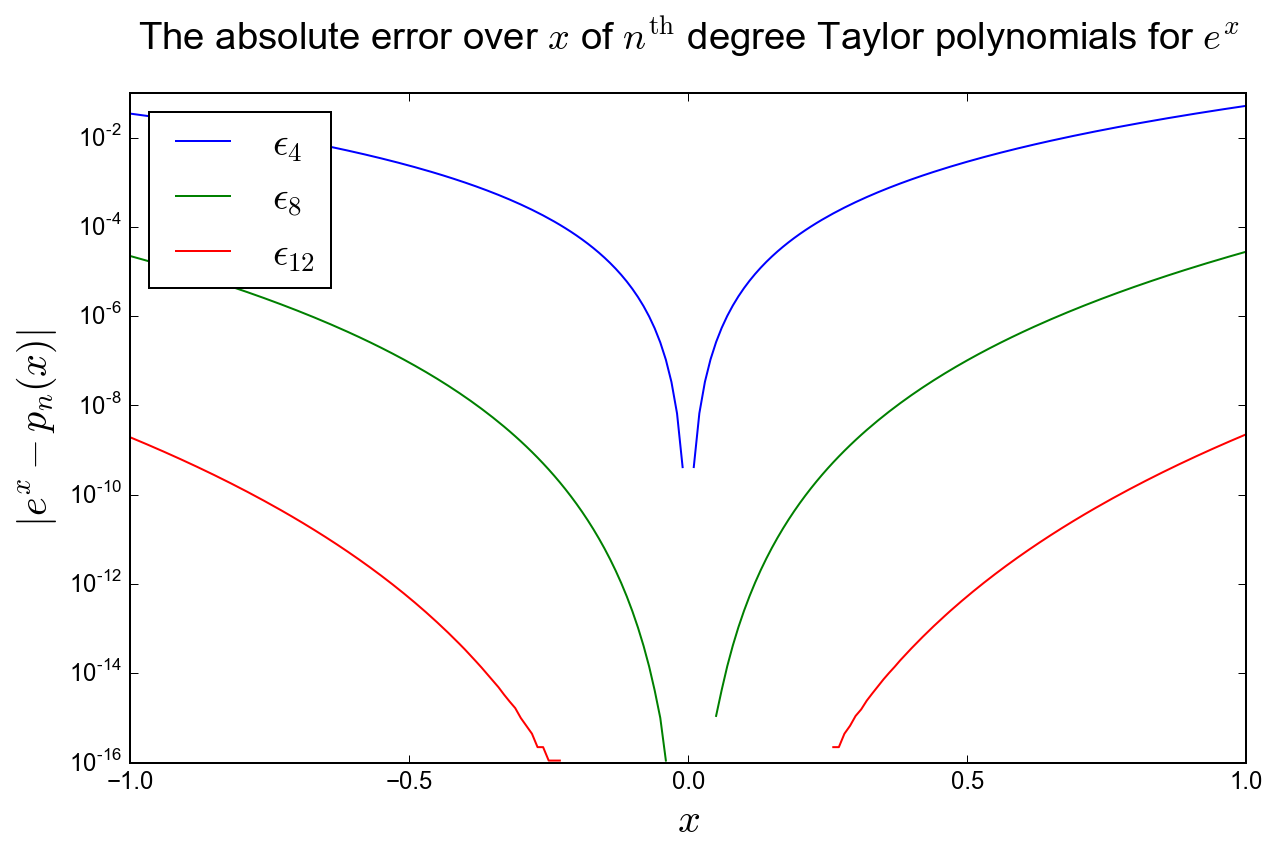

In [23]:
# Plot |e^x−p4(x)|, |e^x −p8(x)| and |e^x−p12(x)| in another 
# figure window using the matplotlib command semilogy, 
# again with a legend, axis labels and a title.

pylab.semilogy(v['z'], v['err4'], 
           v['z'], v['err8'], 
           v['z'], v['err12'])

pylab.legend(('$\epsilon_{4}$',
              '$\epsilon_{8}$',
              '$\epsilon_{12}$'), loc=2)

pylab.xlabel('$x$')
pylab.ylabel('$|e^x-p_n(x)|$')
pylab.title('The absolute error over $x$ of '
            '$n^{\mathrm{th}}$ degree Taylor polynomials '
            'for $e^x$', y=1.05)

### Analysis

By basic observation, one can determine that the absolute error $\epsilon_{12}$, representing the error of $p_{12}(x)$ in approximating $f(x)$, is orders of magnitude lower along the interval $[-1.0,1.0]$ than $\epsilon_{8}$ or $\epsilon_{4}$, meaning that $p_{12}(x)$ is the "best" approximation of $f(x)$, where "best" is defined as having minimized error.

This behavior is expected, as Taylor Polynomials converge at their center point (here, $x=0$) about the actual value $f(x)$ as their degree increases.

Assuming we are to compute upper bounds on the error functions in the set theory sense, i.e. simple maxima, the upper bounds of each Taylor polynomial's absolute error is as follows:

$$
E_4 = \max\limits_{x\in[-1,1]}|\lbrace\epsilon_4\rbrace|
$$

$$
E_8 = \max\limits_{x\in[-1,1]}|\lbrace\epsilon_8\rbrace|
$$

$$
E_{12} = \max\limits_{x\in[-1,1]}|\lbrace\epsilon_{12}\rbrace|
$$

In [24]:
E_4 = max(v['err4'])
E_8 = max(v['err8'])
E_12 = max(v['err12'])
print("E_4:", E_4)
print("E_8:", E_8)
print("E_12:", E_12)

E_4: 0.0516151617924
E_8: 2.78602050767e-05
E_12: 2.26055218988e-09


As expected, these maxima are very consistent with plotted data — compared to $E_4$, $E_8$ is orders of magnitude smaller, and compared to $E_8$, $E_{12}$ is orders of magnitude smaller yet — this is visually evident by the linear spacing on the graph, which, since the $y$-axis is logarithmic, is consistent with these maxima.

### Conclusion

The data generated by this simple program is a solid explanation and representation of the convergent behavior of Taylor polynomials, and underflow behavior (noted in the absolute error graph, where data "disappears" in the middle). The accuracy of the polynomials increases with degree in very predictable and representable ways.